# **Variational Autoencoder**
____

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

### **Step 1: Define the VAE Architecture**
First, you'll define the encoder and decoder as PyTorch modules. The encoder will output parameters for the mean and log variance of the latent variables, and the decoder will reconstruct the input from the latent space.

In [7]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, input_dim)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### **Step 2: Define the Loss Function**
The loss function for a VAE includes both the reconstruction loss and the KL divergence loss, which regularizes the encoder by minimizing the difference between its distribution and the prior.

In [8]:
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
    return MSE + KLD

### **Step 3: Initialize the Model and Optimizer**
Set up the VAE and the optimizer.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(86, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### **Step 4: Training Loop**
Define the training loop to update the weights of the network.

In [19]:
def train(model, device, train_loader, optimizer, epoch, log_interval=500):
    model.train()  # Set the model to training mode
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Ensure data is on the device
        optimizer.zero_grad()  # Zero the gradients
        recon_batch, mu, logvar = model(data)  # Forward pass
        loss = loss_function(recon_batch, data, mu, logvar)  # Calculate loss
        loss.backward()  # Backward pass
        train_loss += loss.item()
        optimizer.step()  # Update the model parameters
        
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

### **Step 5: Data Loading and Training Execution**
Load your data, set up your training parameters, and start the training.

In [31]:
# Load from CSV and split into train and test set
data = pd.read_csv('pt_lab_interp.csv')
data = data.iloc[:, 2:].astype('float32')
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [29]:
# Converting the test set into Torch tensors
tensor_x_train = torch.Tensor(X_train)
tensor_x_test = torch.Tensor(X_test)

# Creating a TensorDataset (assuming we want to use the same data as input and output)
train_dataset = TensorDataset(tensor_x_train, tensor_x_train)
test_dataset = TensorDataset(tensor_x_test, tensor_x_test)

# Create the DataLoader for batching and loading the test data
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # No need to shuffle for testing

In [25]:
# Training the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/6957 (0%)]	Loss: 0.811788
Train Epoch: 1 [2500/6957 (36%)]	Loss: 0.786587
Train Epoch: 1 [5000/6957 (72%)]	Loss: 1.766412
====> Epoch: 1 Average loss: 1.3932
Train Epoch: 2 [0/6957 (0%)]	Loss: 1.002746
Train Epoch: 2 [2500/6957 (36%)]	Loss: 1.151251
Train Epoch: 2 [5000/6957 (72%)]	Loss: 0.750698
====> Epoch: 2 Average loss: 1.3931
Train Epoch: 3 [0/6957 (0%)]	Loss: 1.767886
Train Epoch: 3 [2500/6957 (36%)]	Loss: 1.683098
Train Epoch: 3 [5000/6957 (72%)]	Loss: 2.169970
====> Epoch: 3 Average loss: 1.3919
Train Epoch: 4 [0/6957 (0%)]	Loss: 1.706547
Train Epoch: 4 [2500/6957 (36%)]	Loss: 1.660370
Train Epoch: 4 [5000/6957 (72%)]	Loss: 2.367901
====> Epoch: 4 Average loss: 1.3931
Train Epoch: 5 [0/6957 (0%)]	Loss: 1.524432
Train Epoch: 5 [2500/6957 (36%)]	Loss: 1.603543
Train Epoch: 5 [5000/6957 (72%)]	Loss: 1.128691
====> Epoch: 5 Average loss: 1.3912
Train Epoch: 6 [0/6957 (0%)]	Loss: 1.408590
Train Epoch: 6 [2500/6957 (36%)]	Loss: 1.031088
Train Epoch: 6 [5000/6957 (7

### **Reconstruction Error**
____

In [32]:
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon, mu, logvar = model(data)
        test_loss += loss_function(recon, data, mu, logvar).item()

print(f'Average reconstruction error: {test_loss / len(test_loader.dataset)}')

Average reconstruction error: 1.4228575838023219


### **Visualize Latent Space using TNSE**
____

C:\Users\khngu\AppData\Local\Temp\ipykernel_31780\4152818112.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], cmap='viridis', alpha=0.6)


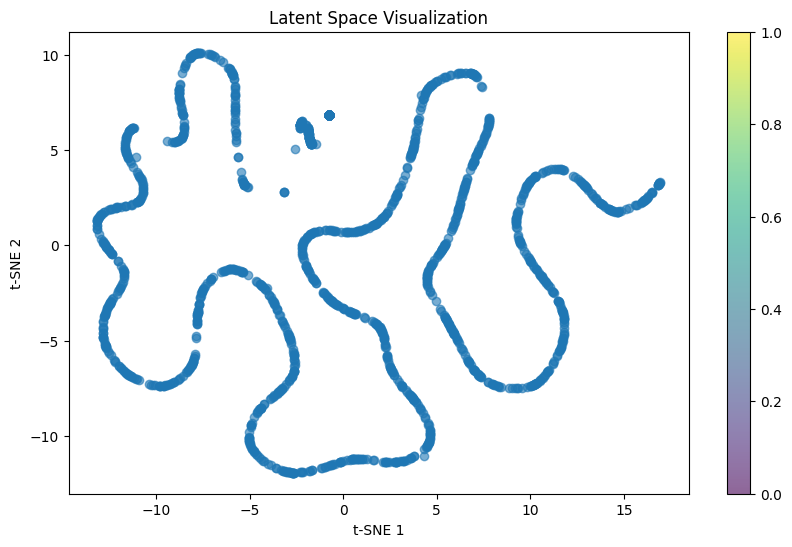

In [27]:
def visualize_latent_space(model, data_loader, device):
    model.eval()
    z_means = []
    labels = []  # Assuming you have labels for each data point
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            z_means.extend(mu.cpu().numpy())
            labels.extend(label.numpy())

    # Convert z_means to a numpy array
    z_means = np.array(z_means)

    # Check if there are enough samples for the specified perplexity
    n_samples = len(z_means)
    perplexity = min(30, n_samples - 1)  # Adjust perplexity based on the number of samples

    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=300)
    z_tsne = tsne.fit_transform(z_means)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.title('Latent Space Visualization')
    plt.show()

visualize_latent_space(model, test_loader, device)

### **Anomaly Detection**
___

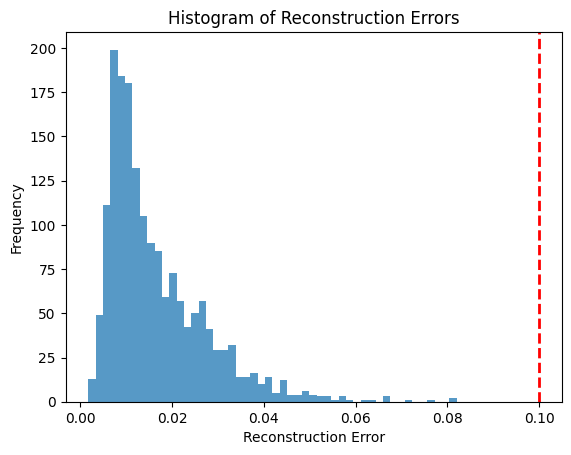

In [28]:
def plot_anomalies(data_loader, model, device, threshold=0.1):
    reconstruction_errors = []
    model.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            reconstructed, _, _ = model(data)
            loss = torch.mean((data - reconstructed) ** 2, dim=1)
            reconstruction_errors.append(loss.cpu().numpy())

    reconstruction_errors = np.concatenate(reconstruction_errors)
    plt.hist(reconstruction_errors, bins=50, alpha=0.75)
    plt.axvline(x=threshold, color='r', linestyle='dashed', linewidth=2)
    plt.title('Histogram of Reconstruction Errors')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.show()

plot_anomalies(test_loader, model, device)